# Pathway activity analysis with GEDI

In [1]:
library(ggpubr)
library(cowplot)
library(pheatmap)
library(scuttle)
library(scran)
library(scater)
library(uwot)
library(SingleCellExperiment)
library(ggplot2)
library(HDF5Array)
library(GEDI)
set.seed(43)

Loading required package: ggplot2


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumpr

In [2]:
pheatmap.colorsymmetric <- function(x,lim=NULL,...)
{
    require(pheatmap)
    if(is.null(lim)){
        lim <- max(abs(x), na.rm=TRUE)
        if( min(x, na.rm=TRUE) < 0 ){
            lim_down<- -lim
            col_palette<- colorRampPalette(c("blue","white","red"))(256)
        }else{        
            lim_down<- 0
            col_palette<- colorRampPalette(c("white","red"))(256)
        }
    }else{
        lim <- 1
        lim_down<- -1
        col_palette<- colorRampPalette(c("blue","white","red"))(256)        
    }
    pheatmap(
        x, color = col_palette,
        breaks=seq(lim_down,lim,length.out=255), ... )
}

## Load data

In [3]:
dir_data <- "~/projects/rrg-hsn/lmoral7/splicing-pancancer/data/singlecell_ccRCC/"
dir_gedi_results <- paste0(dir_data,"gedi_models/")

In [4]:
meta <-readRDS(paste0(dir_data, "meta_ccRCC_primary_tumors.rds"))

umap_res <- readRDS(paste0(dir_data, "umap_res_ccRCC_primary_tumors.rds") ) %>% as.data.frame()
colnames(umap_res)<-c("UMAP1","UMAP2")

sce <- loadHDF5SummarizedExperiment(paste0(dir_data, "my_h5_se/"))
sce <- sce[, rownames(meta)]

## Run GEDI

In [5]:
C <- readRDS("figures_v3_objects/KIRC.gora_res.C_matrix.RDS")
dim(C)

[1] 1044    7

#### Preprocess data

In [6]:
sum_genes<- rowSums(assay(sce, "counts")>5)
genes_use<- sum_genes>3
genes_use<- names(which(genes_use))
sce<- sce[genes_use,]

In [7]:
# Accesing the raw counts in the SCE object and convert to a sparse Matrix format
raw_counts<- as(as.matrix(assay(sce, "counts")), "dgCMatrix")
commongenes<- intersect(rownames(C), rownames(raw_counts) )
C<- C[commongenes,]
raw_counts<- raw_counts[commongenes,]

In [8]:
QR <- qr(crossprod(C))
C <- C[ , QR$pivot[seq_len(QR$rank)] ] # remove any columns that results in singularity
dim(C) 

[1] 864   7

#### Setup GEDI model

In [10]:
## Set up GEDI model
model <- new("GEDI") # Initialize GEDI object
model$setup(Samples = sce$Sample, # Vector indicating which sample belongs to each cell
            colData = meta, # Metadata (optional)
            M = raw_counts, # Expression data
            C = C, # Gene level prior information
            K = 10, # Number of latent variables to use
            mode = "Bsphere", # Modes to use: Either Bsphere (hyperellipsoid) or Bl2 (hyperplane)
            oi_shrinkage = 1)

Setting up the GEDI model...



#### Fit model

In [11]:
model$initialize.LVs(randomSeed = 1) # initialize LVs
model$optimize(iterations=200) # run model with 500 iterations
saveRDS( model, file="figures_v3_objects/KIRC.gedi.model.rds") # Saving output model

Initializing LVs...

  Initializing oi...

  Performing initial decompsition of Y...

Performing block coordinate descent optimization...

  Iteration 1/200 (total 1)...



3.180321 
1 
Mean(o): -1.0058 ; Var(o): 0.4499327 ; Var(si): 0.02525808 


  Iteration 2/200 (total 2)...



2.297633 
1 
Mean(o): -0.986554 ; Var(o): 0.4374536 ; Var(si): 0.1101891 


  Iteration 3/200 (total 3)...



1.890514 
1 
Mean(o): -0.9819278 ; Var(o): 0.42582 ; Var(si): 0.1686058 


  Iteration 4/200 (total 4)...



1.686311 
1 
Mean(o): -0.9793953 ; Var(o): 0.4256362 ; Var(si): 0.1689957 


  Iteration 5/200 (total 5)...



1.563452 
1 
Mean(o): -0.9776673 ; Var(o): 0.4445099 ; Var(si): 0.13986 


  Iteration 6/200 (total 6)...



1.47546 
1 
Mean(o): -0.976661 ; Var(o): 0.4817036 ; Var(si): 0.1121991 


  Iteration 7/200 (total 7)...



1.404027 
1 
Mean(o): -0.9767048 ; Var(o): 0.5330116 ; Var(si): 0.0996283 


  Iteration 8/200 (total 8)...



1.34121 
1 
Mean(o): -0.9780325 ; Var(o): 0.593453 ; Var(si): 0.1035336 


  Iteration 9/200 (total 9)...



1.284524 
1 
Mean(o): -0.9803109 ; Var(o): 0.6581851 ; Var(si): 0.1199837 


  Iteration 10/200 (total 10)...



1.234294 
1 
Mean(o): -0.9829419 ; Var(o): 0.7231133 ; Var(si): 0.1431951 


  Iteration 11/200 (total 11)...



1.191567 
1 
Mean(o): -0.985557 ; Var(o): 0.785345 ; Var(si): 0.1677761 


  Iteration 12/200 (total 12)...



1.156591 
1 
Mean(o): -0.9880393 ; Var(o): 0.8433484 ; Var(si): 0.1900197 


  Iteration 13/200 (total 13)...



1.128483 
1 
Mean(o): -0.990386 ; Var(o): 0.8967188 ; Var(si): 0.2083248 


  Iteration 14/200 (total 14)...



1.105816 
1 
Mean(o): -0.9926249 ; Var(o): 0.9455949 ; Var(si): 0.2226194 


  Iteration 15/200 (total 15)...



1.087292 
1 
Mean(o): -0.9947846 ; Var(o): 0.990145 ; Var(si): 0.2335201 


  Iteration 16/200 (total 16)...



1.07199 
1 
Mean(o): -0.9968868 ; Var(o): 1.030445 ; Var(si): 0.2417846 


  Iteration 17/200 (total 17)...



1.059298 
1 
Mean(o): -0.9989474 ; Var(o): 1.066593 ; Var(si): 0.2480774 


  Iteration 18/200 (total 18)...



1.048774 
1 
Mean(o): -1.000977 ; Var(o): 1.098801 ; Var(si): 0.2529183 


  Iteration 19/200 (total 19)...



1.040068 
1 
Mean(o): -1.002985 ; Var(o): 1.127409 ; Var(si): 0.2566947 


  Iteration 20/200 (total 20)...



1.032882 
1 
Mean(o): -1.004975 ; Var(o): 1.152827 ; Var(si): 0.2596874 


  Iteration 21/200 (total 21)...



1.026966 
1 
Mean(o): -1.006952 ; Var(o): 1.175481 ; Var(si): 0.2620969 


  Iteration 22/200 (total 22)...



1.022105 
1 
Mean(o): -1.008919 ; Var(o): 1.195766 ; Var(si): 0.2640646 


  Iteration 23/200 (total 23)...



1.018125 
1 
Mean(o): -1.010878 ; Var(o): 1.214021 ; Var(si): 0.2656903 


  Iteration 24/200 (total 24)...



1.014879 
1 
Mean(o): -1.01283 ; Var(o): 1.230532 ; Var(si): 0.2670446 


  Iteration 25/200 (total 25)...



1.012247 
1 
Mean(o): -1.014778 ; Var(o): 1.245532 ; Var(si): 0.2681778 


  Iteration 26/200 (total 26)...



1.01013 
1 
Mean(o): -1.016721 ; Var(o): 1.259214 ; Var(si): 0.2691259 


  Iteration 27/200 (total 27)...



1.008444 
1 
Mean(o): -1.018661 ; Var(o): 1.27174 ; Var(si): 0.2699153 


  Iteration 28/200 (total 28)...



1.00712 
1 
Mean(o): -1.020598 ; Var(o): 1.283245 ; Var(si): 0.2705654 


  Iteration 29/200 (total 29)...



1.006099 
1 
Mean(o): -1.022534 ; Var(o): 1.293846 ; Var(si): 0.2710913 


  Iteration 30/200 (total 30)...



1.00533 
1 
Mean(o): -1.024467 ; Var(o): 1.303645 ; Var(si): 0.2715044 


  Iteration 31/200 (total 31)...



1.004771 
1 
Mean(o): -1.0264 ; Var(o): 1.312729 ; Var(si): 0.2718139 


  Iteration 32/200 (total 32)...



1.004387 
1 
Mean(o): -1.028332 ; Var(o): 1.321176 ; Var(si): 0.2720278 


  Iteration 33/200 (total 33)...



1.004148 
1 
Mean(o): -1.030264 ; Var(o): 1.329052 ; Var(si): 0.2721524 


  Iteration 34/200 (total 34)...



1.004027 
1 
Mean(o): -1.032195 ; Var(o): 1.336417 ; Var(si): 0.2721936 


  Iteration 35/200 (total 35)...



1.004004 
1 
Mean(o): -1.034127 ; Var(o): 1.343322 ; Var(si): 0.2721567 


  Iteration 36/200 (total 36)...



1.00406 
1 
Mean(o): -1.036059 ; Var(o): 1.349814 ; Var(si): 0.2720463 


  Iteration 37/200 (total 37)...



1.00418 
1 
Mean(o): -1.037992 ; Var(o): 1.355932 ; Var(si): 0.271867 


  Iteration 38/200 (total 38)...



1.00435 
1 
Mean(o): -1.039926 ; Var(o): 1.361713 ; Var(si): 0.2716227 


  Iteration 39/200 (total 39)...



1.004561 
1 
Mean(o): -1.041861 ; Var(o): 1.367187 ; Var(si): 0.271317 


  Iteration 40/200 (total 40)...



1.004802 
1 
Mean(o): -1.043797 ; Var(o): 1.372382 ; Var(si): 0.2709535 


  Iteration 41/200 (total 41)...



1.005067 
1 
Mean(o): -1.045735 ; Var(o): 1.377323 ; Var(si): 0.270535 


  Iteration 42/200 (total 42)...



1.005349 
1 
Mean(o): -1.047675 ; Var(o): 1.382031 ; Var(si): 0.2700645 


  Iteration 43/200 (total 43)...



1.005644 
1 
Mean(o): -1.049616 ; Var(o): 1.386523 ; Var(si): 0.2695444 


  Iteration 44/200 (total 44)...



1.005947 
1 
Mean(o): -1.051559 ; Var(o): 1.390817 ; Var(si): 0.268977 


  Iteration 45/200 (total 45)...



1.006256 
1 
Mean(o): -1.053504 ; Var(o): 1.394928 ; Var(si): 0.2683645 


  Iteration 46/200 (total 46)...



1.006568 
1 
Mean(o): -1.055451 ; Var(o): 1.398867 ; Var(si): 0.2677089 


  Iteration 47/200 (total 47)...



1.00688 
1 
Mean(o): -1.0574 ; Var(o): 1.402645 ; Var(si): 0.2670118 


  Iteration 48/200 (total 48)...



1.007193 
1 
Mean(o): -1.059352 ; Var(o): 1.406274 ; Var(si): 0.2662749 


  Iteration 49/200 (total 49)...



1.007504 
1 
Mean(o): -1.061306 ; Var(o): 1.40976 ; Var(si): 0.2654998 


  Iteration 50/200 (total 50)...



1.007814 
1 
Mean(o): -1.063262 ; Var(o): 1.413113 ; Var(si): 0.2646878 


  Iteration 51/200 (total 51)...



1.008121 
1 
Mean(o): -1.065221 ; Var(o): 1.41634 ; Var(si): 0.2638404 


  Iteration 52/200 (total 52)...



1.008423 
1 
Mean(o): -1.067183 ; Var(o): 1.419449 ; Var(si): 0.2629597 


  Iteration 53/200 (total 53)...



1.008716 
1 
Mean(o): -1.069147 ; Var(o): 1.422449 ; Var(si): 0.2620479 


  Iteration 54/200 (total 54)...



1.009001 
1 
Mean(o): -1.071115 ; Var(o): 1.425346 ; Var(si): 0.2611069 


  Iteration 55/200 (total 55)...



1.009276 
1 
Mean(o): -1.073085 ; Var(o): 1.428143 ; Var(si): 0.2601378 


  Iteration 56/200 (total 56)...



1.009544 
1 
Mean(o): -1.075058 ; Var(o): 1.430844 ; Var(si): 0.2591414 


  Iteration 57/200 (total 57)...



1.009805 
1 
Mean(o): -1.077034 ; Var(o): 1.433453 ; Var(si): 0.2581186 


  Iteration 58/200 (total 58)...



1.01006 
1 
Mean(o): -1.079013 ; Var(o): 1.435974 ; Var(si): 0.2570704 


  Iteration 59/200 (total 59)...



1.010308 
1 
Mean(o): -1.080996 ; Var(o): 1.43841 ; Var(si): 0.255998 


  Iteration 60/200 (total 60)...



1.01055 
1 
Mean(o): -1.082981 ; Var(o): 1.440767 ; Var(si): 0.2549025 


  Iteration 61/200 (total 61)...



1.010785 
1 
Mean(o): -1.08497 ; Var(o): 1.443046 ; Var(si): 0.2537847 


  Iteration 62/200 (total 62)...



1.011015 
1 
Mean(o): -1.086962 ; Var(o): 1.445253 ; Var(si): 0.2526458 


  Iteration 63/200 (total 63)...



1.011239 
1 
Mean(o): -1.088958 ; Var(o): 1.44739 ; Var(si): 0.2514867 


  Iteration 64/200 (total 64)...



1.011457 
1 
Mean(o): -1.090957 ; Var(o): 1.449461 ; Var(si): 0.2503083 


  Iteration 65/200 (total 65)...



1.01167 
1 
Mean(o): -1.09296 ; Var(o): 1.451468 ; Var(si): 0.2491115 


  Iteration 66/200 (total 66)...



1.011877 
1 
Mean(o): -1.094966 ; Var(o): 1.453415 ; Var(si): 0.2478972 


  Iteration 67/200 (total 67)...



1.01208 
1 
Mean(o): -1.096975 ; Var(o): 1.455303 ; Var(si): 0.2466661 


  Iteration 68/200 (total 68)...



1.012278 
1 
Mean(o): -1.098989 ; Var(o): 1.457137 ; Var(si): 0.2454191 


  Iteration 69/200 (total 69)...



1.012471 
1 
Mean(o): -1.101006 ; Var(o): 1.458917 ; Var(si): 0.244157 


  Iteration 70/200 (total 70)...



1.012659 
1 
Mean(o): -1.103027 ; Var(o): 1.460648 ; Var(si): 0.2428805 


  Iteration 71/200 (total 71)...



1.012842 
1 
Mean(o): -1.105051 ; Var(o): 1.462332 ; Var(si): 0.2415904 


  Iteration 72/200 (total 72)...



1.013021 
1 
Mean(o): -1.10708 ; Var(o): 1.46397 ; Var(si): 0.2402876 


  Iteration 73/200 (total 73)...



1.013194 
1 
Mean(o): -1.109112 ; Var(o): 1.465566 ; Var(si): 0.2389725 


  Iteration 74/200 (total 74)...



1.013363 
1 
Mean(o): -1.111148 ; Var(o): 1.467121 ; Var(si): 0.2376459 


  Iteration 75/200 (total 75)...



1.013528 
1 
Mean(o): -1.113188 ; Var(o): 1.468637 ; Var(si): 0.2363082 


  Iteration 76/200 (total 76)...



1.013688 
1 
Mean(o): -1.115232 ; Var(o): 1.470116 ; Var(si): 0.2349598 


  Iteration 77/200 (total 77)...



1.013845 
1 
Mean(o): -1.117281 ; Var(o): 1.471559 ; Var(si): 0.2336012 


  Iteration 78/200 (total 78)...



1.013998 
1 
Mean(o): -1.119333 ; Var(o): 1.472967 ; Var(si): 0.2322328 


  Iteration 79/200 (total 79)...



1.014148 
1 
Mean(o): -1.121389 ; Var(o): 1.474343 ; Var(si): 0.2308549 


  Iteration 80/200 (total 80)...



1.014295 
1 
Mean(o): -1.12345 ; Var(o): 1.475686 ; Var(si): 0.229468 


  Iteration 81/200 (total 81)...



1.014439 
1 
Mean(o): -1.125515 ; Var(o): 1.476999 ; Var(si): 0.2280725 


  Iteration 82/200 (total 82)...



1.01458 
1 
Mean(o): -1.127584 ; Var(o): 1.478283 ; Var(si): 0.2266688 


  Iteration 83/200 (total 83)...



1.014719 
1 
Mean(o): -1.129657 ; Var(o): 1.479538 ; Var(si): 0.2252573 


  Iteration 84/200 (total 84)...



1.014855 
1 
Mean(o): -1.131735 ; Var(o): 1.480766 ; Var(si): 0.2238384 


  Iteration 85/200 (total 85)...



1.014988 
1 
Mean(o): -1.133817 ; Var(o): 1.481969 ; Var(si): 0.2224126 


  Iteration 86/200 (total 86)...



1.015119 
1 
Mean(o): -1.135903 ; Var(o): 1.483146 ; Var(si): 0.2209802 


  Iteration 87/200 (total 87)...



1.015247 
1 
Mean(o): -1.137994 ; Var(o): 1.484299 ; Var(si): 0.2195417 


  Iteration 88/200 (total 88)...



1.015373 
1 
Mean(o): -1.14009 ; Var(o): 1.485429 ; Var(si): 0.2180973 


  Iteration 89/200 (total 89)...



1.015496 
1 
Mean(o): -1.14219 ; Var(o): 1.486537 ; Var(si): 0.2166476 


  Iteration 90/200 (total 90)...



1.015617 
1 
Mean(o): -1.144294 ; Var(o): 1.487622 ; Var(si): 0.2151929 


  Iteration 91/200 (total 91)...



1.015735 
1 
Mean(o): -1.146403 ; Var(o): 1.488687 ; Var(si): 0.2137337 


  Iteration 92/200 (total 92)...



1.01585 
1 
Mean(o): -1.148517 ; Var(o): 1.489732 ; Var(si): 0.2122703 


  Iteration 93/200 (total 93)...



1.015962 
1 
Mean(o): -1.150636 ; Var(o): 1.490757 ; Var(si): 0.2108033 


  Iteration 94/200 (total 94)...



1.016071 
1 
Mean(o): -1.152759 ; Var(o): 1.491763 ; Var(si): 0.209333 


  Iteration 95/200 (total 95)...



1.016176 
1 
Mean(o): -1.154887 ; Var(o): 1.492751 ; Var(si): 0.2078599 


  Iteration 96/200 (total 96)...



1.016278 
1 
Mean(o): -1.157019 ; Var(o): 1.493721 ; Var(si): 0.2063843 


  Iteration 97/200 (total 97)...



1.016377 
1 
Mean(o): -1.159157 ; Var(o): 1.494674 ; Var(si): 0.2049065 


  Iteration 98/200 (total 98)...



1.016472 
1 
Mean(o): -1.161299 ; Var(o): 1.495609 ; Var(si): 0.2034268 


  Iteration 99/200 (total 99)...



1.016565 
1 
Mean(o): -1.163446 ; Var(o): 1.496528 ; Var(si): 0.2019455 


  Iteration 100/200 (total 100)...



1.016655 
1 
Mean(o): -1.165597 ; Var(o): 1.49743 ; Var(si): 0.200463 


  Iteration 101/200 (total 101)...



1.016741 
1 
Mean(o): -1.167754 ; Var(o): 1.498316 ; Var(si): 0.1989794 


  Iteration 102/200 (total 102)...



1.016826 
1 
Mean(o): -1.169915 ; Var(o): 1.499185 ; Var(si): 0.1974951 


  Iteration 103/200 (total 103)...



1.016907 
1 
Mean(o): -1.172082 ; Var(o): 1.500038 ; Var(si): 0.1960104 


  Iteration 104/200 (total 104)...



1.016987 
1 
Mean(o): -1.174253 ; Var(o): 1.500875 ; Var(si): 0.1945254 


  Iteration 105/200 (total 105)...



1.017064 
1 
Mean(o): -1.176429 ; Var(o): 1.501696 ; Var(si): 0.1930406 


  Iteration 106/200 (total 106)...



1.017139 
1 
Mean(o): -1.17861 ; Var(o): 1.502502 ; Var(si): 0.191556 


  Iteration 107/200 (total 107)...



1.017213 
1 
Mean(o): -1.180796 ; Var(o): 1.503292 ; Var(si): 0.190072 


  Iteration 108/200 (total 108)...



1.017285 
1 
Mean(o): -1.182987 ; Var(o): 1.504066 ; Var(si): 0.1885888 


  Iteration 109/200 (total 109)...



1.017355 
1 
Mean(o): -1.185183 ; Var(o): 1.504825 ; Var(si): 0.1871066 


  Iteration 110/200 (total 110)...



1.017423 
1 
Mean(o): -1.187383 ; Var(o): 1.50557 ; Var(si): 0.1856262 


  Iteration 111/200 (total 111)...



1.017486 
1 
Mean(o): -1.189589 ; Var(o): 1.506304 ; Var(si): 0.1841482 


  Iteration 112/200 (total 112)...



1.017545 
1 
Mean(o): -1.191799 ; Var(o): 1.507026 ; Var(si): 0.1826733 


  Iteration 113/200 (total 113)...



1.017598 
1 
Mean(o): -1.194015 ; Var(o): 1.507738 ; Var(si): 0.1812018 


  Iteration 114/200 (total 114)...



1.017648 
1 
Mean(o): -1.196235 ; Var(o): 1.508438 ; Var(si): 0.1797335 


  Iteration 115/200 (total 115)...



1.017694 
1 
Mean(o): -1.19846 ; Var(o): 1.509126 ; Var(si): 0.1782686 


  Iteration 116/200 (total 116)...



1.017739 
1 
Mean(o): -1.20069 ; Var(o): 1.509801 ; Var(si): 0.176807 


  Iteration 117/200 (total 117)...



1.017781 
1 
Mean(o): -1.202925 ; Var(o): 1.510463 ; Var(si): 0.1753488 


  Iteration 118/200 (total 118)...



1.017822 
1 
Mean(o): -1.205164 ; Var(o): 1.511112 ; Var(si): 0.173894 


  Iteration 119/200 (total 119)...



1.017863 
1 
Mean(o): -1.207408 ; Var(o): 1.511747 ; Var(si): 0.1724428 


  Iteration 120/200 (total 120)...



1.017902 
1 
Mean(o): -1.209657 ; Var(o): 1.512371 ; Var(si): 0.1709953 


  Iteration 121/200 (total 121)...



1.01794 
1 
Mean(o): -1.211911 ; Var(o): 1.512982 ; Var(si): 0.1695521 


  Iteration 122/200 (total 122)...



1.017975 
1 
Mean(o): -1.214169 ; Var(o): 1.513584 ; Var(si): 0.1681135 


  Iteration 123/200 (total 123)...



1.018006 
1 
Mean(o): -1.216432 ; Var(o): 1.514179 ; Var(si): 0.1666803 


  Iteration 124/200 (total 124)...



1.018032 
1 
Mean(o): -1.218699 ; Var(o): 1.514765 ; Var(si): 0.1652526 


  Iteration 125/200 (total 125)...



1.018055 
1 
Mean(o): -1.220971 ; Var(o): 1.515345 ; Var(si): 0.1638304 


  Iteration 126/200 (total 126)...



1.018075 
1 
Mean(o): -1.223248 ; Var(o): 1.515916 ; Var(si): 0.1624137 


  Iteration 127/200 (total 127)...



1.018092 
1 
Mean(o): -1.225529 ; Var(o): 1.516478 ; Var(si): 0.1610024 


  Iteration 128/200 (total 128)...



1.018107 
1 
Mean(o): -1.227814 ; Var(o): 1.517031 ; Var(si): 0.1595964 


  Iteration 129/200 (total 129)...



1.01812 
1 
Mean(o): -1.230104 ; Var(o): 1.517574 ; Var(si): 0.1581957 


  Iteration 130/200 (total 130)...



1.018132 
1 
Mean(o): -1.232398 ; Var(o): 1.518109 ; Var(si): 0.1568005 


  Iteration 131/200 (total 131)...



1.018142 
1 
Mean(o): -1.234696 ; Var(o): 1.518634 ; Var(si): 0.1554107 


  Iteration 132/200 (total 132)...



1.018151 
1 
Mean(o): -1.236999 ; Var(o): 1.519151 ; Var(si): 0.1540266 


  Iteration 133/200 (total 133)...



1.018159 
1 
Mean(o): -1.239305 ; Var(o): 1.519659 ; Var(si): 0.1526482 


  Iteration 134/200 (total 134)...



1.018165 
1 
Mean(o): -1.241616 ; Var(o): 1.520159 ; Var(si): 0.1512755 


  Iteration 135/200 (total 135)...



1.01817 
1 
Mean(o): -1.243931 ; Var(o): 1.520651 ; Var(si): 0.1499088 


  Iteration 136/200 (total 136)...



1.018175 
1 
Mean(o): -1.246249 ; Var(o): 1.521136 ; Var(si): 0.148548 


  Iteration 137/200 (total 137)...



1.018178 
1 
Mean(o): -1.248572 ; Var(o): 1.521612 ; Var(si): 0.1471932 


  Iteration 138/200 (total 138)...



1.01818 
1 
Mean(o): -1.250898 ; Var(o): 1.522081 ; Var(si): 0.1458446 


  Iteration 139/200 (total 139)...



1.018181 
1 
Mean(o): -1.253228 ; Var(o): 1.522543 ; Var(si): 0.1445023 


  Iteration 140/200 (total 140)...



1.018181 
1 
Mean(o): -1.255562 ; Var(o): 1.522997 ; Var(si): 0.1431663 


  Iteration 141/200 (total 141)...



1.01818 
1 
Mean(o): -1.257899 ; Var(o): 1.523445 ; Var(si): 0.1418366 


  Iteration 142/200 (total 142)...



1.018178 
1 
Mean(o): -1.26024 ; Var(o): 1.523886 ; Var(si): 0.1405135 


  Iteration 143/200 (total 143)...



1.018176 
1 
Mean(o): -1.262585 ; Var(o): 1.52432 ; Var(si): 0.1391969 


  Iteration 144/200 (total 144)...



1.018173 
1 
Mean(o): -1.264932 ; Var(o): 1.524748 ; Var(si): 0.137887 


  Iteration 145/200 (total 145)...



1.018169 
1 
Mean(o): -1.267283 ; Var(o): 1.52517 ; Var(si): 0.1365839 


  Iteration 146/200 (total 146)...



1.018164 
1 
Mean(o): -1.269637 ; Var(o): 1.525585 ; Var(si): 0.1352876 


  Iteration 147/200 (total 147)...



1.018159 
1 
Mean(o): -1.271994 ; Var(o): 1.525994 ; Var(si): 0.1339982 


  Iteration 148/200 (total 148)...



1.018153 
1 
Mean(o): -1.274355 ; Var(o): 1.526398 ; Var(si): 0.1327159 


  Iteration 149/200 (total 149)...



1.018146 
1 
Mean(o): -1.276718 ; Var(o): 1.526795 ; Var(si): 0.1314406 


  Iteration 150/200 (total 150)...



1.018139 
1 
Mean(o): -1.279083 ; Var(o): 1.527187 ; Var(si): 0.1301726 


  Iteration 151/200 (total 151)...



1.018132 
1 
Mean(o): -1.281452 ; Var(o): 1.527573 ; Var(si): 0.1289119 


  Iteration 152/200 (total 152)...



1.018123 
1 
Mean(o): -1.283823 ; Var(o): 1.527954 ; Var(si): 0.1276586 


  Iteration 153/200 (total 153)...



1.018115 
1 
Mean(o): -1.286196 ; Var(o): 1.52833 ; Var(si): 0.1264129 


  Iteration 154/200 (total 154)...



1.018105 
1 
Mean(o): -1.288572 ; Var(o): 1.5287 ; Var(si): 0.1251748 


  Iteration 155/200 (total 155)...



1.018095 
1 
Mean(o): -1.29095 ; Var(o): 1.529066 ; Var(si): 0.1239444 


  Iteration 156/200 (total 156)...



1.018085 
1 
Mean(o): -1.29333 ; Var(o): 1.529427 ; Var(si): 0.1227219 


  Iteration 157/200 (total 157)...



1.018073 
1 
Mean(o): -1.295712 ; Var(o): 1.529784 ; Var(si): 0.1215074 


  Iteration 158/200 (total 158)...



1.018062 
1 
Mean(o): -1.298095 ; Var(o): 1.530137 ; Var(si): 0.120301 


  Iteration 159/200 (total 159)...



1.018049 
1 
Mean(o): -1.300481 ; Var(o): 1.530485 ; Var(si): 0.1191028 


  Iteration 160/200 (total 160)...



1.018036 
1 
Mean(o): -1.302867 ; Var(o): 1.53083 ; Var(si): 0.1179128 


  Iteration 161/200 (total 161)...



1.018021 
1 
Mean(o): -1.305255 ; Var(o): 1.53117 ; Var(si): 0.1167313 


  Iteration 162/200 (total 162)...



1.018007 
1 
Mean(o): -1.307645 ; Var(o): 1.531508 ; Var(si): 0.1155582 


  Iteration 163/200 (total 163)...



1.017991 
1 
Mean(o): -1.310035 ; Var(o): 1.531841 ; Var(si): 0.1143937 


  Iteration 164/200 (total 164)...



1.017975 
1 
Mean(o): -1.312425 ; Var(o): 1.532172 ; Var(si): 0.1132379 


  Iteration 165/200 (total 165)...



1.017958 
1 
Mean(o): -1.314817 ; Var(o): 1.532499 ; Var(si): 0.112091 


  Iteration 166/200 (total 166)...



1.01794 
1 
Mean(o): -1.317209 ; Var(o): 1.532823 ; Var(si): 0.1109529 


  Iteration 167/200 (total 167)...



1.017921 
1 
Mean(o): -1.319601 ; Var(o): 1.533145 ; Var(si): 0.1098238 


  Iteration 168/200 (total 168)...



1.017902 
1 
Mean(o): -1.321993 ; Var(o): 1.533464 ; Var(si): 0.1087039 


  Iteration 169/200 (total 169)...



1.017881 
1 
Mean(o): -1.324385 ; Var(o): 1.533779 ; Var(si): 0.1075931 


  Iteration 170/200 (total 170)...



1.01786 
1 
Mean(o): -1.326777 ; Var(o): 1.534093 ; Var(si): 0.1064916 


  Iteration 171/200 (total 171)...



1.017838 
1 
Mean(o): -1.329168 ; Var(o): 1.534404 ; Var(si): 0.1053996 


  Iteration 172/200 (total 172)...



1.017816 
1 
Mean(o): -1.331559 ; Var(o): 1.534712 ; Var(si): 0.1043171 


  Iteration 173/200 (total 173)...



1.017793 
1 
Mean(o): -1.333948 ; Var(o): 1.535018 ; Var(si): 0.1032442 


  Iteration 174/200 (total 174)...



1.017768 
1 
Mean(o): -1.336336 ; Var(o): 1.535321 ; Var(si): 0.102181 


  Iteration 175/200 (total 175)...



1.017744 
1 
Mean(o): -1.338723 ; Var(o): 1.535623 ; Var(si): 0.1011277 


  Iteration 176/200 (total 176)...



1.017718 
1 
Mean(o): -1.341107 ; Var(o): 1.535922 ; Var(si): 0.1000843 


  Iteration 177/200 (total 177)...



1.017692 
1 
Mean(o): -1.34349 ; Var(o): 1.536219 ; Var(si): 0.09905096 


  Iteration 178/200 (total 178)...



1.017665 
1 
Mean(o): -1.345871 ; Var(o): 1.536513 ; Var(si): 0.09802774 


  Iteration 179/200 (total 179)...



1.017637 
1 
Mean(o): -1.348249 ; Var(o): 1.536806 ; Var(si): 0.09701476 


  Iteration 180/200 (total 180)...



1.017609 
1 
Mean(o): -1.350624 ; Var(o): 1.537096 ; Var(si): 0.09601212 


  Iteration 181/200 (total 181)...



1.01758 
1 
Mean(o): -1.352996 ; Var(o): 1.537385 ; Var(si): 0.09501992 


  Iteration 182/200 (total 182)...



1.017551 
1 
Mean(o): -1.355365 ; Var(o): 1.537671 ; Var(si): 0.09403825 


  Iteration 183/200 (total 183)...



1.01752 
1 
Mean(o): -1.35773 ; Var(o): 1.537955 ; Var(si): 0.09306722 


  Iteration 184/200 (total 184)...



1.01749 
1 
Mean(o): -1.360091 ; Var(o): 1.538236 ; Var(si): 0.09210691 


  Iteration 185/200 (total 185)...



1.017459 
1 
Mean(o): -1.362448 ; Var(o): 1.538516 ; Var(si): 0.09115742 


  Iteration 186/200 (total 186)...



1.017427 
1 
Mean(o): -1.364801 ; Var(o): 1.538794 ; Var(si): 0.09021884 


  Iteration 187/200 (total 187)...



1.017395 
1 
Mean(o): -1.367148 ; Var(o): 1.539069 ; Var(si): 0.08929125 


  Iteration 188/200 (total 188)...



1.017363 
1 
Mean(o): -1.36949 ; Var(o): 1.539342 ; Var(si): 0.08837474 


  Iteration 189/200 (total 189)...



1.01733 
1 
Mean(o): -1.371827 ; Var(o): 1.539613 ; Var(si): 0.08746938 


  Iteration 190/200 (total 190)...



1.017297 
1 
Mean(o): -1.374158 ; Var(o): 1.539882 ; Var(si): 0.08657526 


  Iteration 191/200 (total 191)...



1.017264 
1 
Mean(o): -1.376482 ; Var(o): 1.540148 ; Var(si): 0.08569245 


  Iteration 192/200 (total 192)...



1.01723 
1 
Mean(o): -1.3788 ; Var(o): 1.540412 ; Var(si): 0.08482103 


  Iteration 193/200 (total 193)...



1.017196 
1 
Mean(o): -1.381111 ; Var(o): 1.540674 ; Var(si): 0.08396105 


  Iteration 194/200 (total 194)...



1.017162 
1 
Mean(o): -1.383415 ; Var(o): 1.540934 ; Var(si): 0.08311259 


  Iteration 195/200 (total 195)...



1.017128 
1 
Mean(o): -1.385711 ; Var(o): 1.541191 ; Var(si): 0.08227569 


  Iteration 196/200 (total 196)...



1.017094 
1 
Mean(o): -1.387999 ; Var(o): 1.541446 ; Var(si): 0.08145043 


  Iteration 197/200 (total 197)...



1.01706 
1 
Mean(o): -1.390278 ; Var(o): 1.541699 ; Var(si): 0.08063684 


  Iteration 198/200 (total 198)...



1.017026 
1 
Mean(o): -1.392549 ; Var(o): 1.541949 ; Var(si): 0.07983498 


  Iteration 199/200 (total 199)...



1.016992 
1 
Mean(o): -1.394811 ; Var(o): 1.542197 ; Var(si): 0.07904488 


  Iteration 200/200 (total 200)...



1.016959 
1 
Mean(o): -1.397063 ; Var(o): 1.542443 ; Var(si): 0.07826658 


#### Store results

In [13]:
# Generating svd
svd_res <- svd.gedi( model )
embedding_res_svd<- svd_res$v %*% diag(svd_res$d)
colnames(embedding_res_svd)<- paste0("embedding", 1:ncol(embedding_res_svd))

# Generating umap of 2 dimensions
umap_2_res <- umap(embedding_res_svd, min_dist=0.01, metric="euclidean")
colnames(umap_2_res)<- paste0("umap", 1:2)
rownames(umap_2_res)<- model$aux$cellIDs
umap_2_res<- data.frame(umap_2_res)

# Reorder meta
meta<- meta[model$aux$cellIDs,] # GEDI reorders the cells by sample, so we need to reorder our original metadata

# Adding UMAP of n dimensions
umap_n_res <- umap( embedding_res_svd, n_components = ncol(embedding_res_svd), min_dist=0.01, metric="euclidean", verbose=F)
colnames(umap_n_res)<- paste0("umap", 1:ncol(embedding_res_svd))
rownames(umap_n_res)<- model$aux$cellIDs
umap_n_res<- data.frame(umap_n_res)        

# Saving results
lis_res<- list(umap_2_res=umap_2_res,               
               umap_n_res=umap_n_res,               
               svd_res=svd_res)
saveRDS( lis_res, file="figures_v3_objects/lis_res.rds")

## Visualize results

In [5]:
gedi_res <- readRDS("figures_v3_objects/lis_res.rds")
model <- readRDS("figures_v3_objects/KIRC.gedi.model.rds")
meta <- meta[model$aux$cellIDs,]
sce <- sce[,rownames(meta)]

In [6]:
tcga.colors<-rev(c("#EF9A9A","#F8BBD0","#CE93D8","#B39DDB","#9FA8DA",
               "#90CAF9","#81D4FA","#80DEEA","#80CBC4","#A5D6A7",
               "#C5E1A5","#E6EE9C","#FFF59D","#FFE082","#BCAAA4",
               "#F44336","#E91E63","#9C27B0","#673AB7","#3F51B5",
               "#2196F3","#03A9F4","#00BCD4","#009688","#4CAF50",
               "#8BC34A","#CDDC39","#FFC107","#FF9800","#795548"))

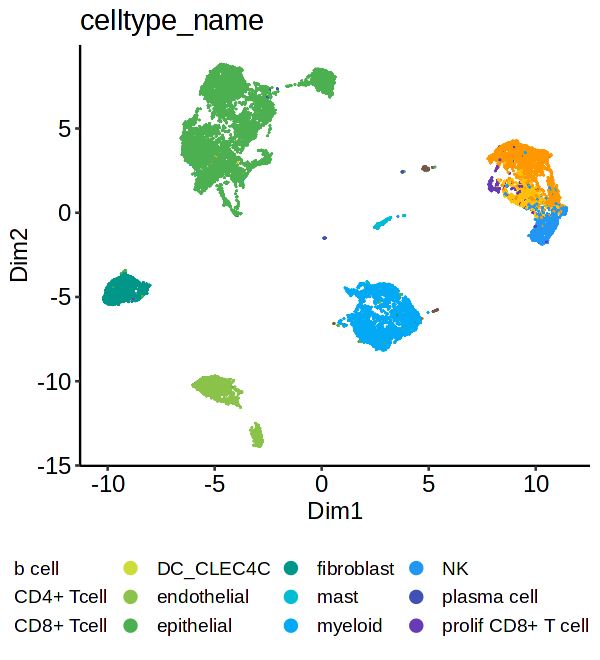

In [40]:
vars_look<- c("simple_Sample", "celltype_name", "infercnv_call", "DF_doublet_call", "log10_sum", "log10_detected", "subsets_mito_percent", "G2M.Score", "S.Score", "Phase", "class", "tumor_site2", "sex", "subtype")
for( var_plot in vars_look[2]){
    p<-ggrastr::rasterise(plot_embedding(gedi_res$umap_2_res, meta[,var_plot]),dpi=500) + 
        labs(title=var_plot) +
        theme_pubr()+
        theme(legend.position="right",text=element_text(size=14))
    
    if(var_plot=="infercnv_call"){
        tn.cols <- c("#8E44AD","#C9C8C8") 
        p<-p+scale_color_manual(values=tn.cols)
    }else if(var_plot=="celltype_name"){
        p<-p+scale_color_manual(values=tcga.colors)+
            theme(legend.position="bottom")+
            labs(color="")
        print(p)
    }
    
    ggsave(p,filename = paste0("figures_v3/KIRC_caseStudy/gedi_pathways/",var_plot,".pdf"),device="pdf",width = 5.5,height=5,units = "in")
}

#### Heatmap of A matrix

In [47]:
A<- getA.gedi(model) # pathways x lvs
pheatmap.colorsymmetric(A,filename = "figures_v3/KIRC_caseStudy/gedi_pathways/heatmap_latentvars.pdf",width = 6,height = 3.5)

#### Project activity of pathways

In [52]:
ADB<- getADB.gedi(model) # pathways x cell

rownames(ADB)<- sub("HALLMARK_", "", rownames(ADB) )
var_ADB<- apply(ADB, 1, var)
top_pathways<- names(sort(var_ADB, decreasing=T)[1:7])

ggdat<- data.frame(var_ADB=var_ADB, pathways=names(var_ADB) )

ggdat<- ggdat[ggdat$pathways %in% top_pathways,]
ggdat$pathways<- factor(ggdat$pathways, levels=top_pathways)

g<-ggplot(ggdat,aes(x=pathways, y=var_ADB) ) +
    geom_bar(stat="identity") +
    theme_pubr()+
    theme(axis.text.x=element_text(size=10,angle=60,hjust=1) )+
    labs(y="Variance in ADB")
ggsave(g,filename = "figures_v3/KIRC_caseStudy/gedi_pathways/pathways_varPlot.pdf",width = 3,height = 3.8,units = "in")

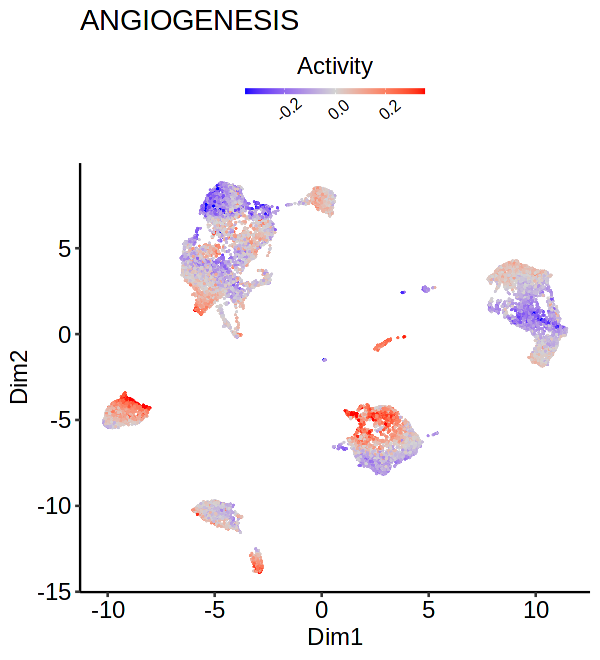

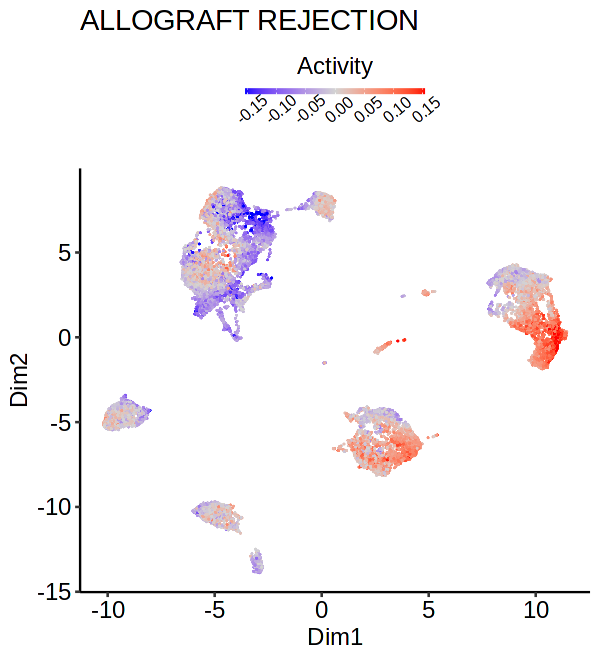

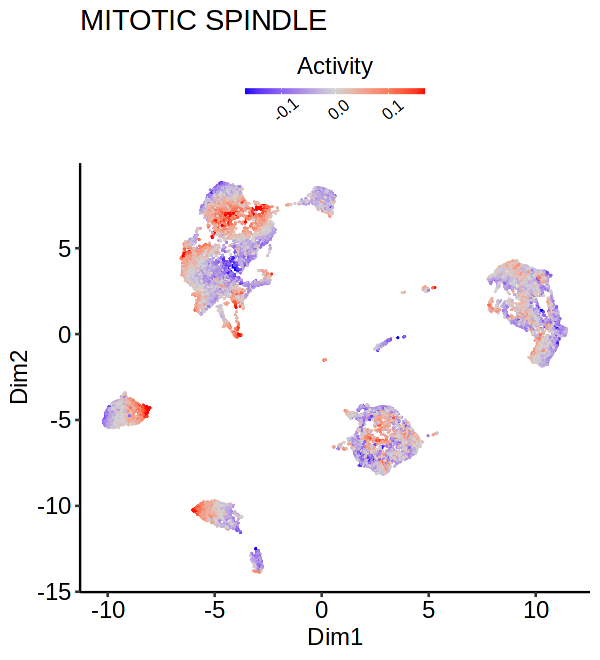

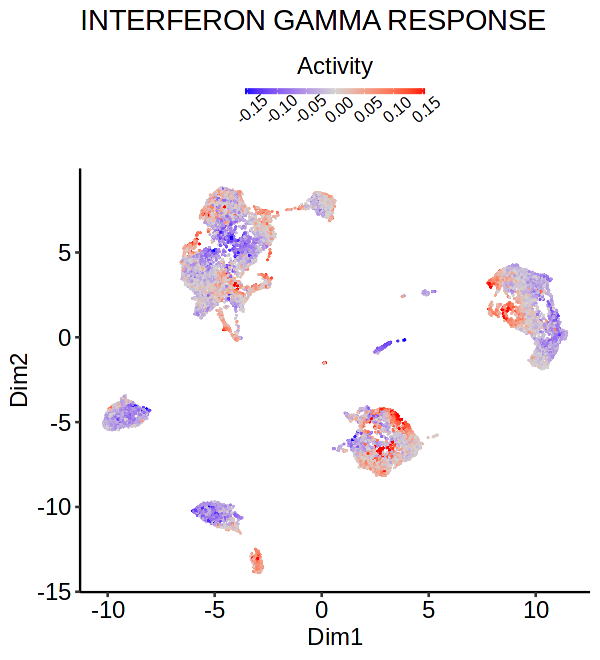

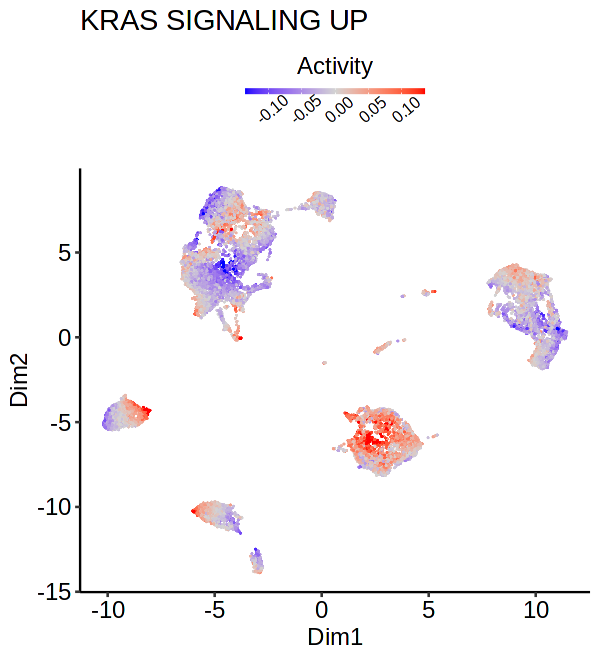

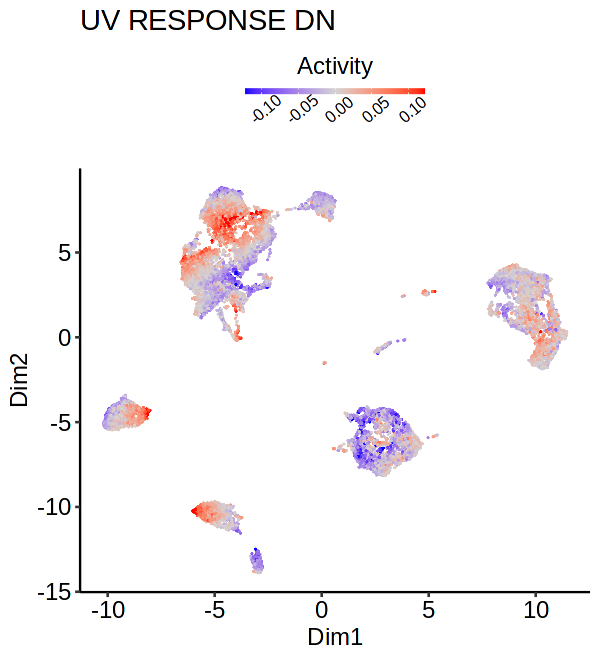

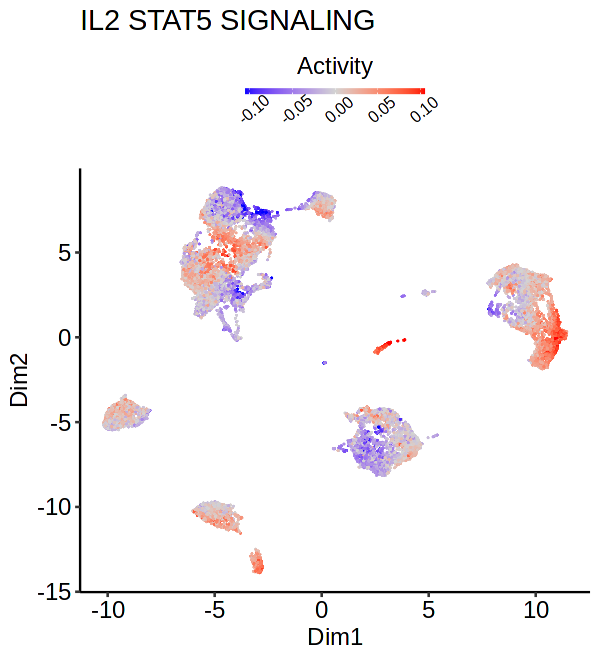

In [41]:
options(repr.plot.width=5,repr.plot.height=5.5)
for(var_plot in top_pathways){
    p<-ggrastr::rasterise(plot_embedding(gedi_res$umap_2_res, ADB[var_plot,]),dpi=500) + 
        labs(title=gsub("_"," ",var_plot),color="Activity") +
        theme_pubr()+
        theme(legend.position = "top",
              text = element_text(size=14))+
        guides(color = guide_colourbar(direction = "horizontal", 
                                         barheight = 0.25,
                                         barwidth = 7.5,
                                         title.position = "top",
                                         title.hjust = 0.5,
                                         label.position = "bottom",
                                         label.theme = element_text(angle = 40,vjust=1,size=9)))
    ggsave(p,filename = paste0("figures_v3/KIRC_caseStudy/gedi_pathways/",var_plot,".pdf"),device="pdf",width = 5,height=5.5,units = "in")
    print(p)
}